<a href="https://colab.research.google.com/github/Tilakraj-B/cardiac-disease/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = "/content/drive/MyDrive/acdc_dataset.zip"  # Update this path
extract_folder = "/content/acdc_data"

In [4]:
# Step 3: Extract the dataset if not already extracted
if not os.path.exists(extract_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")


Extracting dataset...
Extraction complete.


In [13]:
def extract_cfg_values(file_path):
    """
    Extracts key-value pairs from a simple .cfg file.

    Args:
        file_path (str): The path to the .cfg file.

    Returns:
        dict: A dictionary containing the extracted key-value pairs.
              Returns None if the file is not found.
    """
    config = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):  # Ignore empty lines and comments
                    if ':' in line:
                        key, value = line.split(':', 1)
                        config[key.strip()] = value.strip()
                    elif '=' in line:
                        key, value = line.split('=', 1)
                        config[key.strip()] = value.strip()
        return config
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
# 4. Print the extracted dictionary
# if config_data:
#     print(config_data)

#     # 5. Access individual values
#     ed_value = config_data.get('ED')
#     es_value = config_data.get('ES')
#     group_value = config_data.get('Group')
#     height_value = config_data.get('Height')
#     nbframe_value = config_data.get('NbFrame')
#     weight_value = config_data.get('Weight')

#     print(f"\nExtracted Values:")
#     print(f"ED: {ed_value}")
#     print(f"ES: {es_value}")
#     print(f"Group: {group_value}")
#     print(f"Height: {height_value}")
#     print(f"NbFrame: {nbframe_value}")
#     print(f"Weight: {weight_value}")

In [5]:
def load_nii_file(filepath):
    img = nib.load(filepath)
    data = img.get_fdata()
    return data


In [6]:
# Step 5: Load and visualize a sample image (Modify the path based on extracted files)
base_dir = os.path.join(extract_folder,"database")
training_folder = os.path.join(extract_folder,"database","training")
testing_folder = os.path.join(extract_folder,"database","testing")
train_patients = [f'patient{i:03d}' for i in range(1, 100)]
test_patients = [f'patient{i:03d}' for i in range(1, 50)]

# info_file_path = os.path.join(patient_folder, "Info.cfg")

# if os.path.exists(info_file_path):
#     with open(info_file_path, "r") as file:
#         info_content = file.read()
#     print("Contents of Info.cfg:\n")
#     print(info_content)
# else:
#     print("Info.cfg not found. Check the path!")



In [7]:
# Display all the images of a patient

def display_nifti_slices(nifti_path):
    nifti_img = nib.load(nifti_path)  # Load NIfTI file
    image_data = nifti_img.get_fdata()  # Convert to NumPy array

    print(f"\nDisplaying slices for {os.path.basename(nifti_path)}")
    print(f"Image shape: {image_data.shape}")  # Print shape

    dim = image_data.ndim  # Get number of dimensions
    if dim == 2:  # Case: 2D Image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_data, cmap="gray")
        plt.title(f"{os.path.basename(nifti_path)} - 2D Image")
        plt.axis("off")
        plt.show()

    elif dim == 3:  # Case: 3D Image (H, W, D)
        num_slices = image_data.shape[2]
        for i in range(num_slices):
            plt.figure(figsize=(6, 6))
            plt.imshow(image_data[:, :, i], cmap="gray")
            plt.title(f"{os.path.basename(nifti_path)} - Slice {i+1}/{num_slices}")
            plt.axis("off")
            plt.show()

    elif dim == 4:  # Case: 4D Image (H, W, D, T)
        num_slices = image_data.shape[2]
        num_timeframes = image_data.shape[3]
        for t in range(num_timeframes):  # Loop over time
            for i in range(num_slices):  # Loop over depth
                plt.figure(figsize=(6, 6))
                plt.imshow(image_data[:, :, i, t], cmap="gray")
                plt.title(f"{os.path.basename(nifti_path)} - Time {t+1}/{num_timeframes} - Slice {i+1}/{num_slices}")
                plt.axis("off")
                plt.show()

    else:
        print(f"Unsupported image dimension: {dim}")

In [ ]:
# # displaying dimension and shape of the imagedatabase
# for i in range(1,100):
#   patient_folder = os.path.join(training_folder, f"patient{i:03d}")
#   for filename in sorted(os.listdir(patient_folder)):
#     if filename.endswith(".nii"):
#       nifti_path = os.path.join(patient_folder, filename)
#       # display_nifti_slices(nifti_path)
#       nifti_img = nib.load(nifti_path)  # Load NIfTI file
#       image_data = nifti_img.get_fdata()  # Convert to NumPy array
#       dim = image_data.ndim
#       # print(filename + " : " + str(dim) + " dimensions" + str(image_data.shape))


In [8]:
# Define a function to extract the ROI based on the ground truth mask
def extract_roi(image_slice, mask_slice, margin=10):
    """
    Given an image and its binary mask, this function computes the bounding box
    around the mask and crops both the image and mask with an optional margin.
    """
    # Find coordinates of the mask pixels
    coords = np.where(mask_slice > 0)
    if coords[0].size == 0 or coords[1].size == 0:
        # If no ROI found, return the original slices
        return image_slice, mask_slice

    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()

    # Add margin (ensuring we stay within image bounds)
    y_min = max(y_min - margin, 0)
    y_max = min(y_max + margin, image_slice.shape[0])
    x_min = max(x_min - margin, 0)
    x_max = min(x_max + margin, image_slice.shape[1])

    return image_slice[y_min:y_max, x_min:x_max], mask_slice[y_min:y_max, x_min:x_max]


In [ ]:
def load_patient_data(patient_folder, es_or_ed):
    # Get all .nii files in the folder
    info = extract_cfg_values(os.path.join(patient_folder, "Info.cfg"))
    es = info.get('ES')
    ed = info.get('ED')
    if es_or_ed == 'ES':
      files = [f for f in os.listdir(patient_folder) if f.endswith(es + '.nii') and f.endswith(es + '_gt.nii')]
    else:
      files = [f for f in os.listdir(patient_folder) if f.endswith(ed + '.nii') and f.endswith(ed + '_gt.nii')]


    # Separate image and ground truth files
    image_files = [f for f in files if not f.endswith('_gt.nii')]
    gt_files = [f for f in files if f.endswith('_gt.nii')]

    images = []
    masks = []

    for img_file, gt_file in zip(sorted(image_files), sorted(gt_files)):
        img_data = load_nii_file(os.path.join(patient_folder, img_file))
        gt_data = load_nii_file(os.path.join(patient_folder, gt_file))

        #iterating through each slice in the model
        for slice_idx in range(img_data.shape[2]):
            img_slice = img_data[..., slice_idx]
            gt_slice = gt_data[..., slice_idx]

            # Normalize and resize if needed
            img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
            gt_slice = (gt_slice > 0).astype(np.float32)  # Binarize if needed

            # ROI Extraction Step
            img_slice, gt_slice = extract_roi(img_slice, gt_slice, margin=10)

            # Resize to make dimensions divisible by 16 for U-Net (optional)
            img_slice = tf.image.resize(img_slice[..., np.newaxis], [224, 256])
            gt_slice = tf.image.resize(gt_slice[..., np.newaxis], [224, 256])

            images.append(img_slice.numpy())
            masks.append(gt_slice.numpy())

    return np.array(images), np.array(masks)




In [5]:
def load_dataset(root_folder, patient_range):
    all_images = []
    all_masks = []

    for patient_id in patient_range:
        patient_folder = os.path.join(root_folder, f"patient{patient_id:03d}")
        if os.path.exists(patient_folder):
            images, masks = load_patient_data(patient_folder , 'ES')
            all_images.extend(images)
            all_masks.extend(masks)
            images, masks = load_patient_data(patient_folder , 'ED')
            all_images.extend(images)
            all_masks.extend(masks)

    return np.array(all_images), np.array(all_masks)


In [10]:
def unet_model(input_size=(224, 256, 1)):
    inputs = Input(input_size)

    # Downsample path with fewer filters
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Upsample path
    up1 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge1 = concatenate([conv3, up1], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up2 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge2 = concatenate([conv2, up2], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up3 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge3 = concatenate([conv1, up3], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [11]:
def train_model():
    # Load training data
    train_images, train_masks = load_dataset(training_folder, range(1, 101))

    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_masks, test_size=0.2, random_state=42
    )

    # Create model
    model = unet_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])])

    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
    ]

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=16,
        epochs=100,
        callbacks=callbacks
    )

    return model, history

In [ ]:
def apply_kmeans_with_filters(segmented_image, k=3):

    # Apply Gaussian smoothing filter
    smoothed_image = cv2.GaussianBlur(segmented_image, (5, 5), 0)

    # Define a sharpening kernel and apply it
    kernel_sharpening = np.array([[-1, -1, -1],
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened_image = cv2.filter2D(smoothed_image, -1, kernel_sharpening)

    # Flatten the sharpened image for clustering
    flat_image = sharpened_image.reshape(-1, 1)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(flat_image)

    # Reshape the cluster labels back to the original image shape
    clustered = kmeans.labels_.reshape(segmented_image.shape)
    return clustered, smoothed_image, sharpened_image


In [ ]:
def evaluate_model(model):
    # Load test data
    test_images, test_masks = load_dataset(testing_folder, range(101, 151))  # Assuming test data range is 101-150

    # Evaluate
    results = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test IoU: {results[2]}")

    # Predict
    predicted_mask = model.predict(test_images[:10])



    plt.figure(figsize=(20, 10))
    for i in range(10):
        original_image = test_images[i].squeeze()
        true_mask = test_masks[i].squeeze()
        pred_mask = (predicted_mask[i].squeeze() > 0.7).astype(np.uint8)  # Binary mask

        # Extract predicted region
        segmented_image = original_image * pred_mask  # Element-wise multiplication

        # Apply K-means clustering to the segmented image to get 3 regions
        kmeans_clusters, smoothed_image, sharpened_image = apply_kmeans_with_filters(segmented_image, 3)

        plt.subplot(7, 10, i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Input')
        plt.axis('off')

        plt.subplot(7, 10, i + 11)
        plt.imshow(true_mask, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(7, 10, i + 21)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Prediction Mask')
        plt.axis('off')

        plt.subplot(7, 10, i + 31)
        plt.imshow(segmented_image, cmap='gray')
        plt.title('Segmented Region')
        plt.axis('off')

        # Plot K-means Clustering Result (3 regions)
        plt.subplot(7, 10, i + 41)
        plt.imshow(kmeans_clusters, cmap='jet')
        plt.title('K-means Clusters')
        plt.axis('off')

        plt.subplot(7, 10, i + 51)
        plt.imshow(smoothed_image, cmap='jet')
        plt.title('K-means Clusters')
        plt.axis('off')

        plt.subplot(7, 10, i + 61)
        plt.imshow(sharpened_image, cmap='jet')
        plt.title('K-means Clusters')
        plt.axis('off')


    plt.tight_layout()
    plt.show()


In [12]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [ ]:
    if not os.path.exists('unet_mri_segmentation.keras'):
      model, history = train_model()
      model.save('unet_mri_segmentation.keras')
      plot_training_history(history)
    else:
      model = tf.keras.models.load_model('unet_mri_segmentation.keras')

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6524 - io_u: 0.0000e+00 - loss: 0.6421

96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 483ms/step - accuracy: 0.6528 - io_u: 0.0000e+00 - loss: 0.6416 - val_accuracy: 0.7367 - val_io_u: 0.0000e+00 - val_loss: 0.4534
Epoch 2/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8034 - io_u: 0.0000e+00 - loss: 0.3925

96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.8038 - io_u: 0.0000e+00 - loss: 0.3918 - val_accuracy: 0.8617 - val_io_u: 0.0000e+00 - val_loss: 0.2798
Epoch 3/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8630 - io_u: 0.0000e+00 - loss: 0.2711

96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.8631 - io_u: 0.0000e+00 - loss: 0.2710 - val_accuracy: 0.8755 - val_io_u: 0.0000e+00 - val_loss: 0.2445
Epoch 4/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8782 - io_u: 0.0000e+00 - loss: 0.2400

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.8783 - io_u: 0.0000e+00 - loss: 0.2397 - val_accuracy: 0.8966 - val_io_u: 0.0000e+00 - val_loss: 0.2005
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.8911 - io_u: 0.0000e+00 - loss: 0.2116 - val_accuracy: 0.8893 - val_io_u: 0.0000e+00 - val_loss: 0.2154
Epoch 6/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8946 - io_u: 0.0000e+00 - loss: 0.2031

96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.8946 - io_u: 0.0000e+00 - loss: 0.2030 - val_accuracy: 0.9044 - val_io_u: 0.0000e+00 - val_loss: 0.1837
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.8844 - io_u: 0.0000e+00 - loss: 0.2280 - val_accuracy: 0.8961 - val_io_u: 0.0000e+00 - val_loss: 0.2019
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.8952 - io_u: 0.0000e+00 - loss: 0.2032 - val_accuracy: 0.8695 - val_io_u: 0.0000e+00 - val_loss: 0.2495
Epoch 9/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9016 - io_u: 0.0000e+00 - loss: 0.1869

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - accuracy: 0.9016 - io_u: 0.0000e+00 - loss: 0.1868 - val_accuracy: 0.9063 - val_io_u: 0.0000e+00 - val_loss: 0.1815
Epoch 10/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9101 - io_u: 0.0000e+00 - loss: 0.1670

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.9102 - io_u: 0.0000e+00 - loss: 0.1669 - val_accuracy: 0.9159 - val_io_u: 0.0000e+00 - val_loss: 0.1507
Epoch 11/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9163 - io_u: 0.0000e+00 - loss: 0.1482

96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - accuracy: 0.9163 - io_u: 0.0000e+00 - loss: 0.1482 - val_accuracy: 0.9179 - val_io_u: 0.0000e+00 - val_loss: 0.1449
Epoch 12/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9224 - io_u: 0.0000e+00 - loss: 0.1329

96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.9224 - io_u: 0.0000e+00 - loss: 0.1329 - val_accuracy: 0.9199 - val_io_u: 8.3963e-06 - val_loss: 0.1384
Epoch 13/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.9204 - io_u: 1.2042e-06 - loss: 0.1354 - val_accuracy: 0.8984 - val_io_u: 0.0000e+00 - val_loss: 0.1998
Epoch 14/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.9224 - io_u: 5.1690e-05 - loss: 0.1307 - val_accuracy: 0.9085 - val_io_u: 0.0000e+00 - val_loss: 0.1677
Epoch 15/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9245 - io_u: 1.2771e-04 - loss: 0.1262

96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.9246 - io_u: 1.3134e-04 - loss: 0.1259 - val_accuracy: 0.9281 - val_io_u: 1.9366e-05 - val_loss: 0.1158
Epoch 16/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9306 - io_u: 4.6426e-04 - loss: 0.1082

96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.9306 - io_u: 4.7057e-04 - loss: 0.1081 - val_accuracy: 0.9286 - val_io_u: 4.0085e-05 - val_loss: 0.1137
Epoch 17/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.9351 - io_u: 0.0012 - loss: 0.0966 - val_accuracy: 0.8988 - val_io_u: 0.0000e+00 - val_loss: 0.1761
Epoch 18/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - accuracy: 0.9296 - io_u: 0.0014 - loss: 0.1120 - val_accuracy: 0.9255 - val_io_u: 2.9888e-04 - val_loss: 0.1224
Epoch 19/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.9336 - io_u: 0.0034 - loss: 0.1003 - val_accuracy: 0.9239 - val_io_u: 6.4191e-05 - val_loss: 0.1276
Epoch 20/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9356 - io_u: 0.0061 - loss: 0.0958

96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.9356 - io_u: 0.0061 - loss: 0.0957 - val_accuracy: 0.9329 - val_io_u: 0.0038 - val_loss: 0.1013
Epoch 21/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9369 - io_u: 0.0077 - loss: 0.0919

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 269ms/step - accuracy: 0.9369 - io_u: 0.0078 - loss: 0.0918 - val_accuracy: 0.9348 - val_io_u: 7.0176e-04 - val_loss: 0.0977
Epoch 22/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 261ms/step - accuracy: 0.9410 - io_u: 0.0102 - loss: 0.0809 - val_accuracy: 0.9347 - val_io_u: 0.0017 - val_loss: 0.0979
Epoch 23/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9409 - io_u: 0.0196 - loss: 0.0813

96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.9410 - io_u: 0.0197 - loss: 0.0813 - val_accuracy: 0.9374 - val_io_u: 0.0163 - val_loss: 0.0911
Epoch 24/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 250ms/step - accuracy: 0.9437 - io_u: 0.0287 - loss: 0.0734 - val_accuracy: 0.9263 - val_io_u: 0.0041 - val_loss: 0.1237
Epoch 25/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 258ms/step - accuracy: 0.9403 - io_u: 0.0208 - loss: 0.0836 - val_accuracy: 0.9376 - val_io_u: 0.0244 - val_loss: 0.0916
Epoch 26/100
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9447 - io_u: 0.0279 - loss: 0.0709

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.9447 - io_u: 0.0280 - loss: 0.0709 - val_accuracy: 0.9384 - val_io_u: 0.0348 - val_loss: 0.0883
Epoch 27/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.9471 - io_u: 0.0485 - loss: 0.0646 - val_accuracy: 0.9387 - val_io_u: 0.1010 - val_loss: 0.0905
Epoch 28/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.9474 - io_u: 0.0760 - loss: 0.0620 - val_accuracy: 0.9318 - val_io_u: 0.0171 - val_loss: 0.1100
Epoch 29/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.9418 - io_u: 0.0359 - loss: 0.0788 - val_accuracy: 0.9385 - val_io_u: 0.1403 - val_loss: 0.0926
Epoch 30/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.9487 - io_u: 0.0941 - loss: 0.0601 - val_accuracy: 0.9389 - val_io_u: 0.0877 - val_loss: 0.0910
Epoch 31/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - accuracy: 0.9475 - io_u: 0.0855 - loss: 0.0635 - val_accuracy: 0.9386 - val_io_u: 0.0589 - val_loss: 0.0907
Epoch 32/100
95/96 ━━━━

96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.9512 - io_u: 0.1229 - loss: 0.0536 - val_accuracy: 0.9398 - val_io_u: 0.1147 - val_loss: 0.0876
Epoch 33/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - accuracy: 0.9510 - io_u: 0.1435 - loss: 0.0532 - val_accuracy: 0.9374 - val_io_u: 0.0915 - val_loss: 0.0978
Epoch 34/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.9486 - io_u: 0.1126 - loss: 0.0599 - val_accuracy: 0.9386 - val_io_u: 0.1791 - val_loss: 0.0954
Epoch 35/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.9503 - io_u: 0.1509 - loss: 0.0553 - val_accuracy: 0.9389 - val_io_u: 0.0990 - val_loss: 0.0953
Epoch 36/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 269ms/step - accuracy: 0.9519 - io_u: 0.1544 - loss: 0.0502 - val_accuracy: 0.9398 - val_io_u: 0.1799 - val_loss: 0.0960
Epoch 37/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.9536 - io_u: 0.2420 - loss: 0.0449 - val_accuracy: 0.9375 - val_io_u: 0.1544 - val_loss: 0.1058
Epoch 38/100
96/96 ━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.9406 - io_u: 0.3324 - loss: 0.1149
Test Loss: 0.11876285076141357, Test Accuracy: 0.9394053220748901, Test IoU: 0.3439668118953705
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


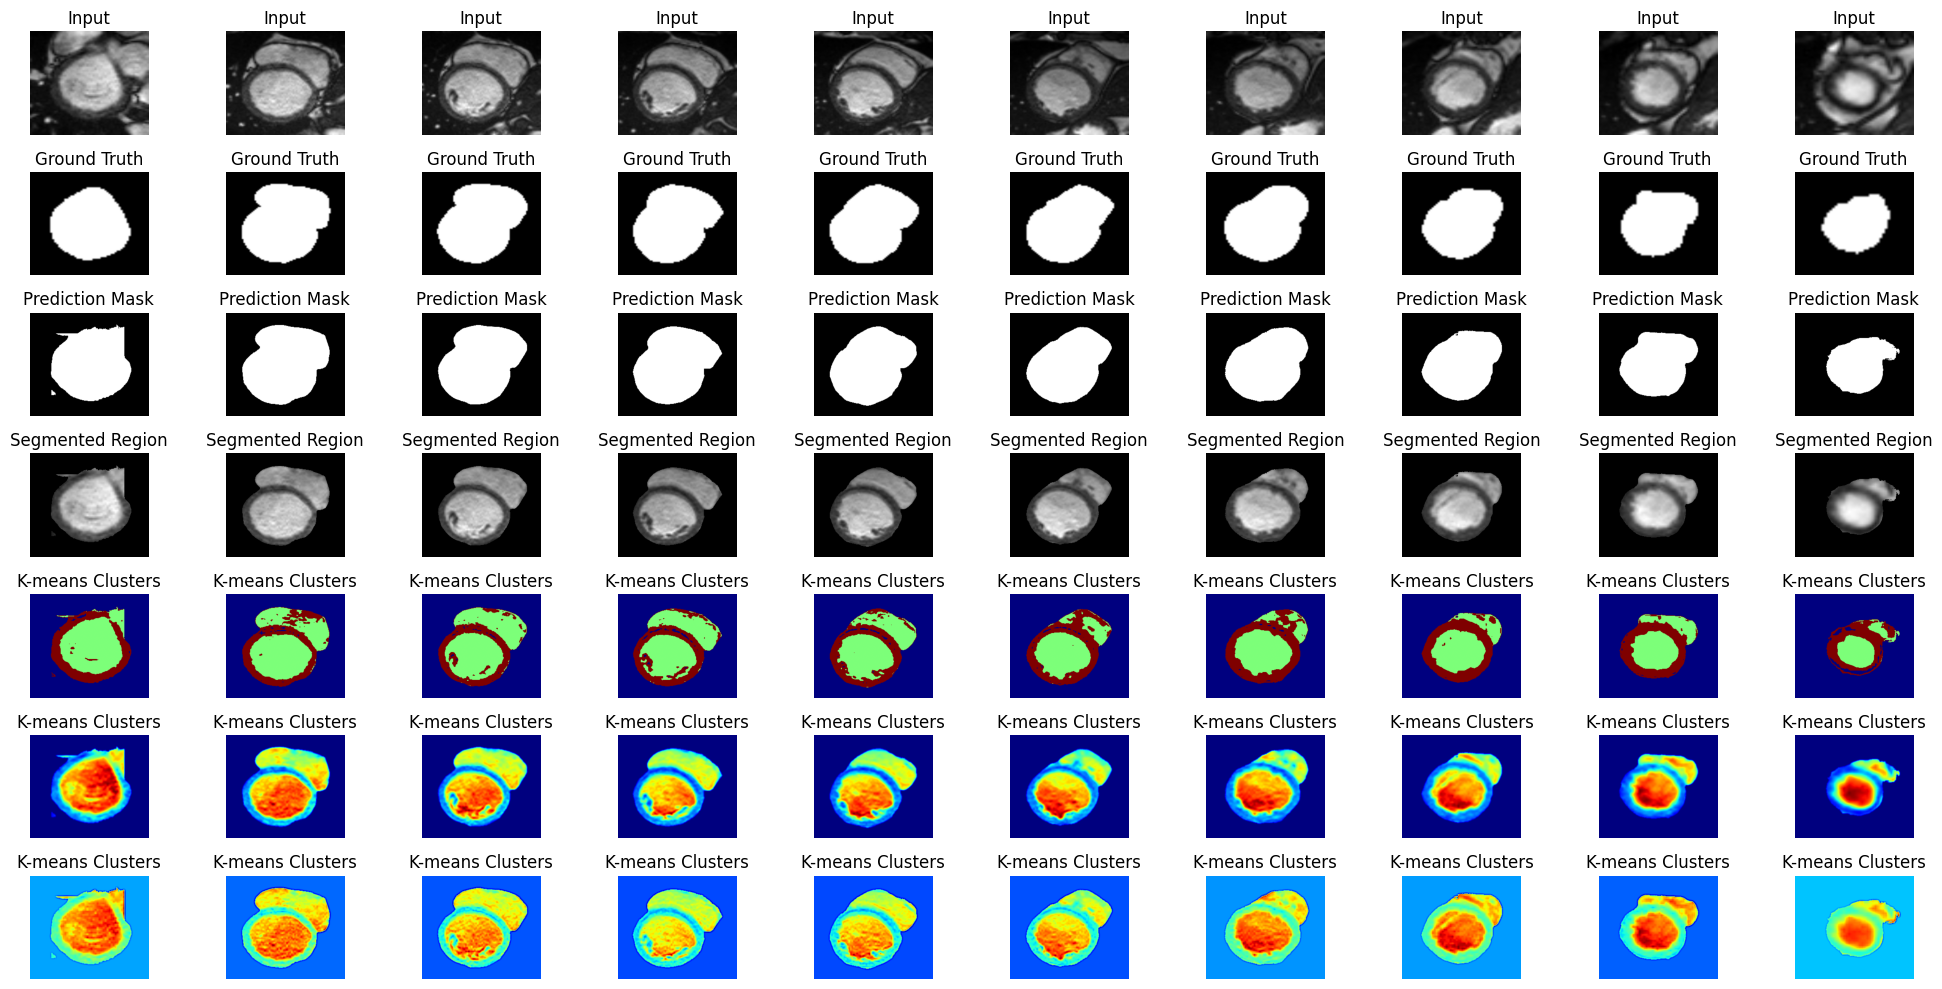

In [ ]:
    # Evaluate on test set
    evaluate_model(model)